In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'darkgrid')

# Import Dataset

In [2]:
hydroswot = pd.read_csv('./HYDRoSWOT/SWOT_ADCP_Dataset.csv', converters={'site_no': str}, low_memory=False)
hydroswot.shape

(223022, 75)

This stipulation requires that each record include the `station identifier`,` latitude` and `longitude`, `the altitude of the gage at the station`, `the drainage area contributing to flow at the station`, and a `measured discharge`, `width`, `mean velocity`, and `mean depth`. We also stipulate that each record includes both `the maximum velocity` and `the maximum depth`.

In [4]:
candidate_columns=['site_no', 'dec_lat_va', 'dec_long_va', 'alt_va', 'drain_area_va', 'q_va', 'stream_wdth_va', 'mean_vel_va', 'mean_depth_va', 'max_vel_va', 'max_depth_va']

df = hydroswot.dropna(axis=0, how='any', subset=candidate_columns)
df.shape

(42553, 75)

To avoid the possible effects of localized obstructions in small channels that might cause highly variable hydraulic conditions, we restricted the analysis to streamflow measurements with top width greater than 15 $m$ and contributing drainage area greater than 13 $km^2$.

In [5]:
df = df[(df['drain_area_va'] > 5.01933) & (df['stream_wdth_va'] > 15)]
df.shape

(42178, 75)

we excluded negative flows from tidal effects and any records where (1) the maximum depth or velocity is less than the mean depth or velocity; (2) the ratio of maximum‐to‐mean velocity exceeds 10 (under the assumption that if the ratio is greater than this, the cross-section may contain extreme irregularities or multiple channels); and (3) the reported discharge is more than 5% greater or less than the discharge calculated by multiplying the reported width, mean depth, and mean velocity.

In [6]:
# negative flows from tidal effects
df = df[(df['q_va'] > 0.0)]
df.shape

(41990, 75)

In [7]:
# the maximum velocity is less than the mean velocity
df = df[(df['max_vel_va'] > df['mean_vel_va'])]
df.shape

(41933, 75)

In [8]:
# the maximum depth is less than the mean depth
df = df[(df['max_depth_va'] > df['mean_depth_va'])]
df.shape

(41755, 75)

In [9]:
# the ratio of maximum‐to‐mean velocity exceeds 10
df = df[(df['max_vel_va'] / df['mean_vel_va'] < 10)]
df.shape

(38377, 75)

In [10]:
# the reported discharge is more than 5% greater or less than the discharge calculated by multiplying the reported width, mean depth, and mean velocity
df = df[(df['q_va'] < 1.05 * df['mean_vel_va'] * df['stream_wdth_va'] * df['mean_depth_va'])]
df = df[(0.95 * df['mean_vel_va'] * df['stream_wdth_va'] * df['mean_depth_va'] < df['q_va'])]
df.shape

(23966, 75)

In [11]:
candidate_columns = ['site_no', 'drain_area_va', 'q_va', 'stage_va', 'stream_wdth_va', 'xsec_area_va', 'mean_vel_va', 'mean_depth_va']

dataset = df[candidate_columns]
dataset = dataset.dropna(axis=0, how='any')
dataset = dataset[(dataset != 0).all(axis=1)]
dataset.reset_index(inplace=True, drop=True)
dataset.shape

(23746, 8)

In [11]:
# dataset = dataset[(dataset['stage_va'] > dataset['stage_va'].quantile(0.01)) & (dataset['stage_va'] < dataset['stage_va'].quantile(0.99))]

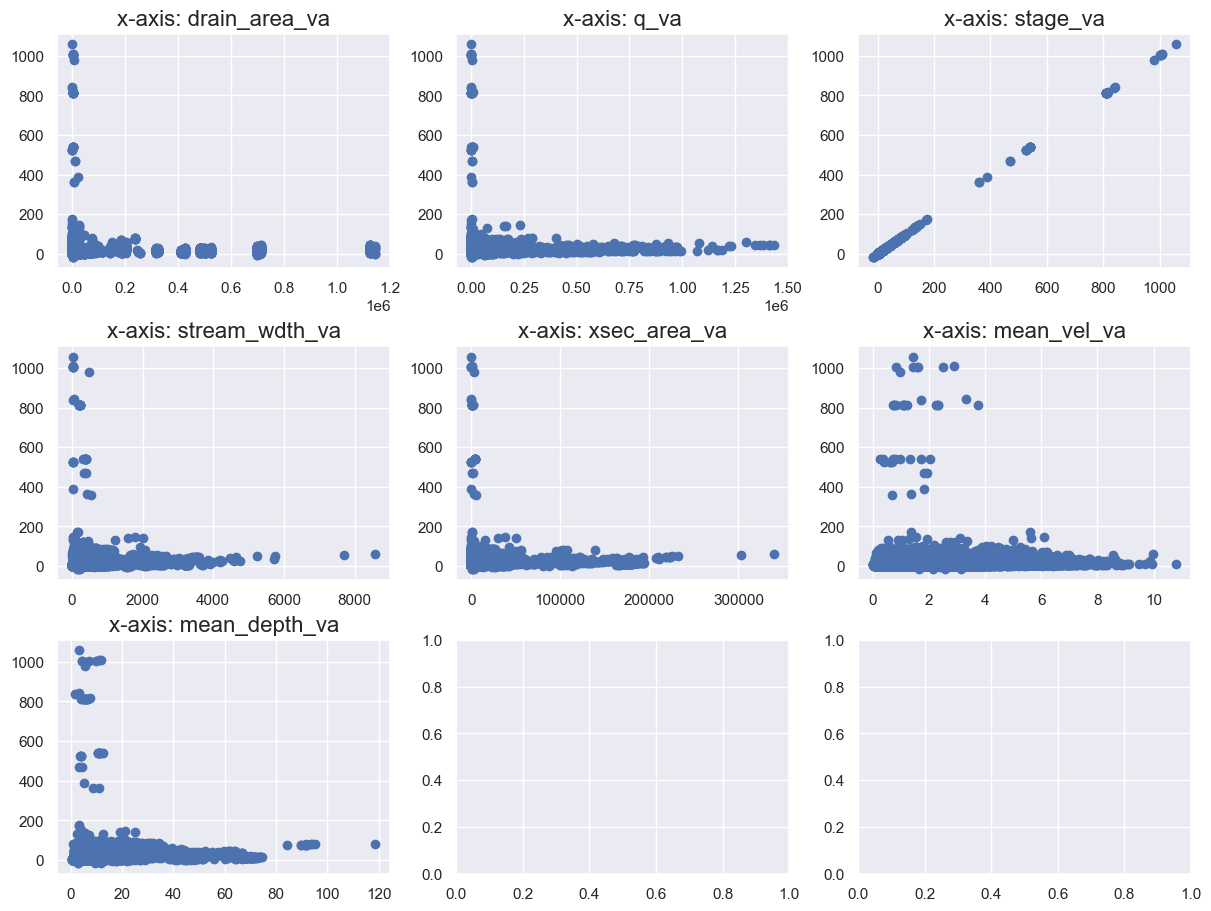

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=3 , figsize=(12, 9), constrained_layout=True)

for index, (column_name, column_data) in enumerate(dataset.drop(columns=['site_no']).iteritems()):
    # print(column_name, column_data); continue
    i, j = divmod(index, 3)

    axes[i, j].scatter(column_data, dataset['stage_va'])
    axes[i, j].set_title(f'x-axis: {column_name}', fontsize=16)
    # axes[i, j].set_xlabel('')

# plt.savefig(f'{data_root}/results/boxplots.png')
plt.show()

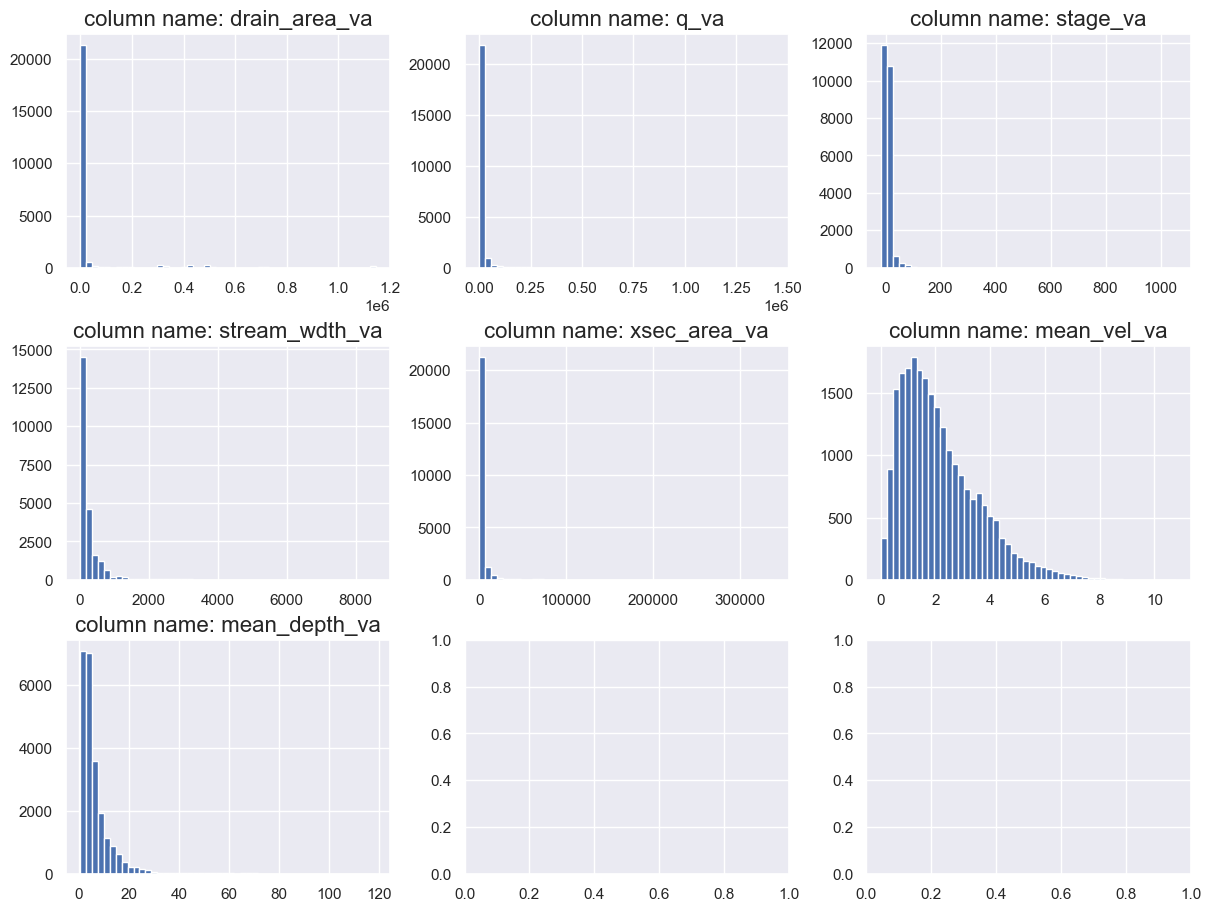

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=3 , figsize=(12, 9), constrained_layout=True)

for index, (column_name, column_data) in enumerate(dataset.drop(columns=['site_no']).iteritems()):
    i, j = divmod(index, 3)

    axes[i, j].hist(column_data, bins=50)
    axes[i, j].set_title(f'column name: {column_name}', fontsize=16)
    # axes[i, j].set_xlabel('')

# plt.savefig(f'{data_root}/results/boxplots.png')
plt.show()

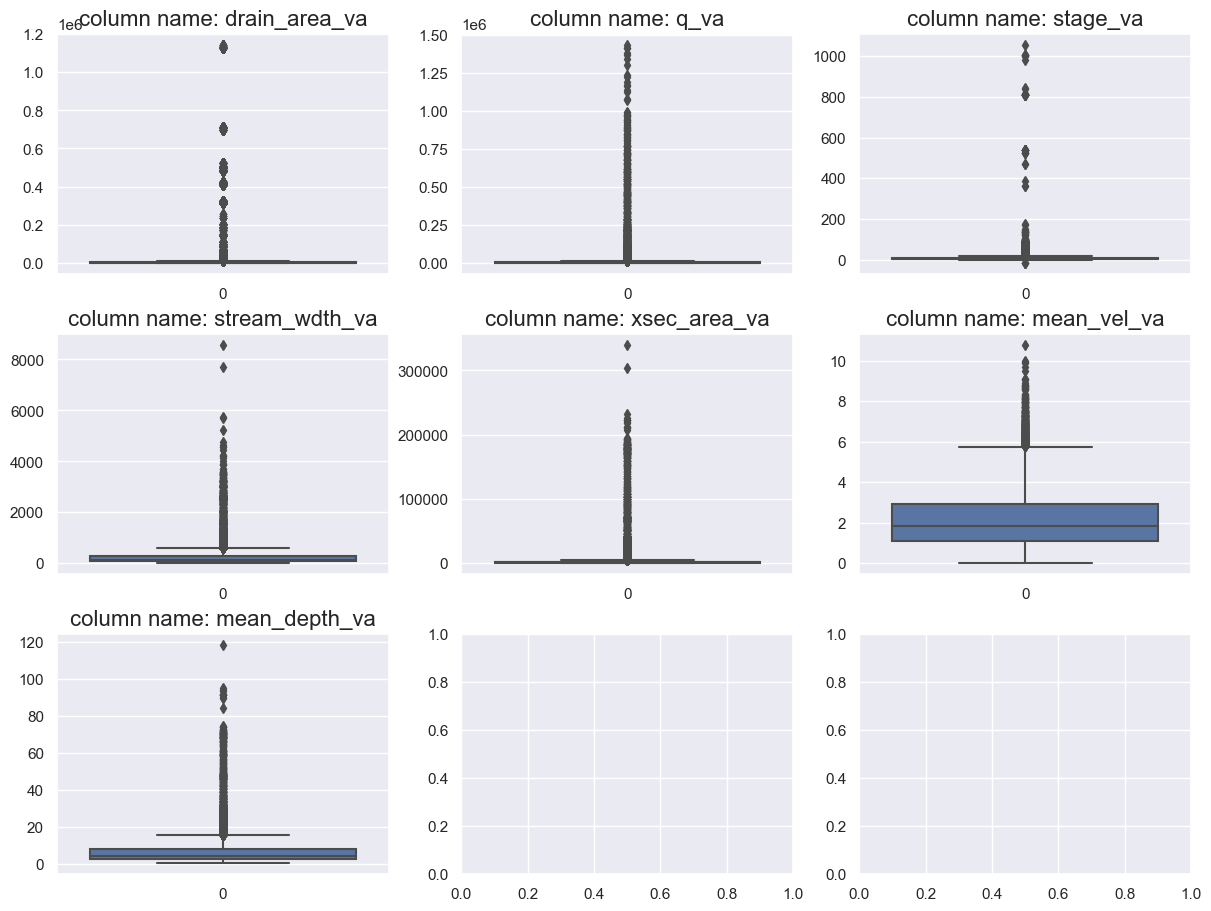

In [14]:
# Boxplot
fig, axes = plt.subplots(nrows=3, ncols=3 , figsize=(12, 9), constrained_layout=True)

for index, (column_name, column_data) in enumerate(dataset.drop(columns=['site_no']).iteritems()):
    # print(column_name, column_data); continue
    i, j = divmod(index, 3)

    sns.boxplot(data=column_data, orient='v', ax=axes[i, j])
    axes[i, j].set_title(f'column name: {column_name}', fontsize=16)
    # axes[i, j].set_xlabel('')

# plt.savefig(f'{data_root}/results/boxplots.png')
plt.show()

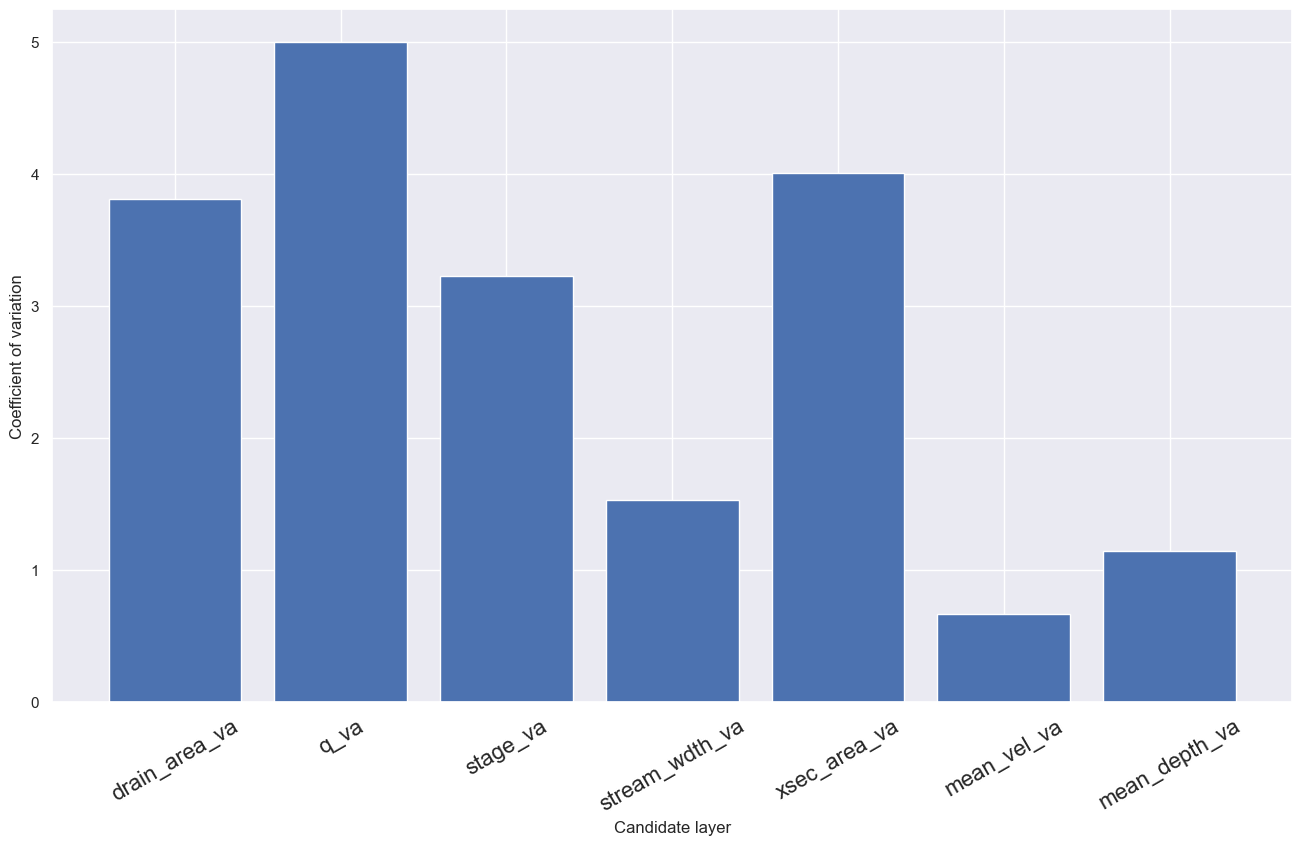

In [15]:
# coefficient of variation
cv_df = dataset.drop(columns=['site_no']).std() / dataset.drop(columns=['site_no']).mean()
cv_df = cv_df.reset_index().rename(columns={'index':'layer_name', 0:'cv'})
fig, ax = plt.subplots(figsize=(16,9))

ax.bar(cv_df['layer_name'], cv_df['cv'])
ax.tick_params(axis='x', labelrotation=30, labelsize=16)
ax.set_xlabel('Candidate layer')
ax.set_ylabel('Coefficient of variation')

# plt.savefig(f'{data_root}/results/cv.png')
plt.show()

In [16]:
from sklearn.model_selection import GroupShuffleSplit

splitter = GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 7)
split = splitter.split(dataset, groups=dataset['site_no'])
train_idx, test_idx = next(split)

train = dataset.iloc[train_idx]
test = dataset.iloc[test_idx]

print(train.shape, test.shape)

(18958, 8) (4788, 8)


In [18]:
train.to_csv('./data/SynDepth_train_set.csv', sep=',', encoding='utf-8', index=False)
test.to_csv('./data/SynDepth_test_set.csv', sep=',', encoding='utf-8', index=False)